In [1]:
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn import preprocessing

In [2]:
df = pd.read_csv('hida_workspace/HackathonCovidData/trainSet/trainSet.txt')

In [3]:
df.head()

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_131,P_131.png,D,35.913889,0,39.3,1.0,0.0,5.76,43.4,651.0,387.0,157.0,94.0,NaN,NaN,NaN,0.0,NaN,MILD
1,P_132,P_132.png,D,57.266667,0,37.0,0.0,0.0,11.48,64.0,700.0,338.0,601.0,94.0,75.0,96.9,7.42,0.0,NaN,MILD
2,P_195,P_195.png,D,79.263889,0,37.8,1.0,0.0,6.21,115.3,698.0,356.0,448.0,94.0,63.0,94.6,7.39,1.0,NaN,SEVERE
3,P_193,P_193.png,D,82.000000,0,38.0,1.0,0.0,7.28,149.3,513.0,482.0,NaN,97.0,68.0,96.3,7.46,0.0,NaN,SEVERE
4,P_140,P_140.png,D,60.791667,1,37.0,1.0,0.0,6.37,20.7,NaN,NaN,210.0,93.0,NaN,97.3,NaN,0.0,NaN,MILD


In [4]:
df.isnull().mean()

PatientID                0.000000
ImageFile                0.000000
Hospital                 0.000000
Age                      0.001159
Sex                      0.000000
Temp_C                   0.178447
Cough                    0.005794
DifficultyInBreathing    0.004635
WBC                      0.010429
CRP                      0.038239
Fibrinogen               0.684820
LDH                      0.157590
Ddimer                   0.719583
Ox_percentage            0.281576
PaO2                     0.196987
SaO2                     0.675550
pH                       0.239861
CardiovascularDisease    0.022016
RespiratoryFailure       0.184241
Prognosis                0.000000
dtype: float64

In [5]:
def make_train_test(df, col):
    # only keep rows with no missing values in col
    test = df.copy()
    test.dropna(subset=[col], inplace=True)
    train = test.copy()

    # remove some values in col (same fraction as in complete dataset)
    test_index = test.sample(frac=ratio_missing[col]).index
    test = test.loc[test_index]
    train.loc[test_index, col] = np.nan
    
    return train, test

In [6]:
# TODO: remove hospital (test only contains one)

In [7]:
# example imputation
def impute(df):
    le = preprocessing.LabelEncoder()
    df.Hospital = le.fit_transform(df.Hospital.values)
    imputer = IterativeImputer(max_iter=1000)
    # imputer = KNNImputer()
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    df_imputed.Hospital = le.inverse_transform(df_imputed.Hospital.astype(int))
    return df_imputed

In [8]:
# added some first additional steps: round binary columns, enforce some upper and lower limits
def impute(df):
    le = preprocessing.LabelEncoder()
    df.Hospital = le.fit_transform(df.Hospital.values)
    # imputer = IterativeImputer(max_iter=1000)
    imputer = KNNImputer()
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    df_imputed.Hospital = le.inverse_transform(df_imputed.Hospital.astype(int))
    
    # round binary cols
    binary_cols = ['Sex', 'Cough', 'CardiovascularDisease', 'RespiratoryFailure', 'DifficultyInBreathing']
    for c in binary_cols:
        df_imputed[c] = df_imputed[c].round()
        
    df_imputed.SaO2.clip(upper=100)
    df_imputed.Ox_percentage.clip(upper=100)
    
    numeric_cols = df_imputed.select_dtypes(include=np.number).columns.tolist()
    for c in numeric_cols:
        df_imputed[c] = df_imputed[c].clip(lower=0)

    return df_imputed

In [9]:
df = df.drop(columns=['PatientID', 'ImageFile', 'Prognosis'])

In [10]:
# dicts that contain the ratio of nans and the standard deviations of each column
ratio_missing = dict(df.isnull().mean())
sd_dict = dict(df.std())

In [11]:
# def imputation_error(y_true, y_pred, variable):
#     return ((((y_true-y_pred)/sd_dict[variable])**2).clip(upper=1)).mean()

# y_true = test.Ox_percentage
# y_pred = train_imputed.Ox_percentage

# imputation_error(test.Ox_percentage, train_imputed.Ox_percentage, 'Ox_percentage')

In [12]:
def imputation_error(test, train, variable):
    return ((((test[variable]-train[variable])/sd_dict[variable])**2).clip(upper=1)).mean()

In [13]:
def imputation_error(test, train, variable):
    return ((((test[variable]-train.loc[test.index, variable])/sd_dict[variable])**2).clip(upper=1)).mean()

In [14]:
train, test = make_train_test(df, 'Ox_percentage')

In [15]:
train.Ox_percentage.isnull().mean()

0.28225806451612906

In [16]:
test.Ox_percentage.isnull().mean()

0.0

In [17]:
train_imputed = impute(train)

In [18]:
imputation_error(test, train_imputed, 'Ox_percentage')

0.44870593486893945

In [71]:
cols = df.columns[df.isnull().any()]

scores = dict()
for c in cols:
    train, test = make_train_test(df, c)
    train_imputed = impute(train)
    scores[c] = imputation_error(test, train_imputed, c)

In [72]:
scores

{'Age': 0.578182452050116,
 'Temp_C': 0.5190992672007854,
 'Cough': 0.6,
 'DifficultyInBreathing': 0.25,
 'WBC': 0.294393564720578,
 'CRP': 0.23808629329940814,
 'Fibrinogen': 0.4639112780525155,
 'LDH': 0.28747575463725344,
 'Ddimer': 0.12106837041573631,
 'Ox_percentage': 0.4562889721122612,
 'PaO2': 0.29599758046464114,
 'SaO2': 0.3067489014436227,
 'pH': 0.559120440125901,
 'CardiovascularDisease': 0.21052631578947367,
 'RespiratoryFailure': 0.007692307692307693}

In [73]:
np.mean(list((scores.values())))

0.34590609986697335

In [74]:
# mean of all column scores
def score_all(df):
    cols = df.columns[df.isnull().any()]
    scores = []
    for c in cols:
        train, test = make_train_test(df, c)
        train_imputed = impute(train)
        #train_imputed = train.fillna(0)
        scores.append(imputation_error(test, train_imputed, c))
    
    return np.mean(scores)

In [75]:
score_all(df)

0.37654768636682373

### First results

In [22]:
# Baseline: fill in 0
score_all(df)

0.705442981767169

In [28]:
# iterative imputer
score_all(df)

0.367744005479485

In [30]:
# iterative imputer + rounding
score_all(df)

/software/all/jupyter/tensorflow/lib/python3.6/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


0.3641668091870941

In [26]:
# iterative imputer + rounding + clip
score_all(df)

0.3458147102691536

In [39]:
# KNN
score_all(df)

0.3840858938580805

In [42]:
# KNN + rounding
score_all(df)

0.36352692488050603

In [45]:
# KNN + rounding + clip
score_all(df)

0.32025929459168373

TODO: Crossvalidation, tune knn, quantile/rank mapping?, maybe try random mask over full df (not column wise)

For the purpose of this challenge, data from 5 of the 6 centers constitute the training set and will be provided as collected (raw, 863 subjects). Data from the last center (120 subjects) is used as testing set to
rank the solutions. --> remove hospital

# Exploration

In [293]:
train, test = make_train_test(df, 'Ox_percentage')

In [294]:
train.Ox_percentage.isnull().mean()

0.28225806451612906

In [295]:
test.Ox_percentage.isnull().mean()

0.0

In [296]:
train_imputed = impute(train)

In [297]:
imputation_error(test, train_imputed, 'Ox_percentage')

0.08417399139315458

In [241]:
train_imputed

,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure
24,E,56.0,0.0,38.300000,0.0,1.0,7.85,9.00,435.512576,159.000000,-326.351538,93.000000,73.200000,95.066745,7.470000,0.0,0.000000
25,E,61.0,0.0,38.000000,1.0,1.0,3.57,57.40,563.930864,309.000000,562.468914,92.000000,57.000000,90.617858,7.470000,0.0,0.000000
26,E,45.0,0.0,38.100000,1.0,0.0,4.36,65.00,745.325082,240.000000,-1380.409273,93.000000,67.366894,88.998086,7.452109,0.0,-0.015138
27,E,64.0,0.0,36.000000,1.0,0.0,5.26,41.90,824.176033,299.000000,-541.819893,96.000000,72.200000,90.135066,7.510000,1.0,0.022202
28,E,54.0,0.0,36.600000,1.0,0.0,7.01,67.90,844.121804,458.000000,1260.884463,97.000000,61.000000,90.176614,7.450000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,F,51.0,0.0,37.811985,0.0,1.0,14.30,22.79,550.000000,368.000000,5027.000000,91.581918,85.703203,92.116627,7.439079,0.0,0.000000
859,F,57.0,0.0,37.578150,1.0,0.0,5.10,8.93,757.000000,451.000000,1698.927286,92.082008,70.100199,90.608888,7.450781,0.0,0.000000
860,F,38.0,0.0,37.539624,0.0,1.0,7.30,0.23,634.332260,363.704962,1073.000000,92.917239,75.229847,91.314407,7.449435,0.0,0.011135
861,F,92.0,1.0,38.000000,0.0,1.0,13.50,3.77,533.000000,358.000000,2154.000000,84.593327,75.700000,93.127091,7.360000,0.0,0.000000


In [342]:
train.describe()

,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure
count,620.000000,619.000000,620.000000,564.000000,618.000000,619.000000,616.000000,603.000000,182.000000,510.000000,145.000000,445.000000,535.000000,200.000000,514.000000,603.000000,472.000000
mean,2.245161,64.887938,0.335484,37.525532,0.519417,0.487884,7.071119,41.510763,622.000000,383.982392,2715.158621,92.482022,72.478131,91.349500,7.453438,0.306799,0.010593
std,0.976902,15.333443,0.472541,0.970481,0.500028,0.500257,3.606074,65.227653,146.974046,263.748516,7747.193283,7.108879,26.560914,9.226246,0.053736,0.461548,0.102485
min,0.000000,18.000000,0.000000,35.400000,0.000000,0.000000,0.200000,0.010000,102.000000,0.020000,130.000000,56.000000,23.000000,29.000000,7.048000,0.000000,0.000000
25%,1.000000,54.000000,0.000000,36.800000,0.000000,0.000000,4.700000,6.040000,522.250000,248.000000,334.000000,90.000000,57.950000,88.000000,7.430000,0.000000,0.000000
50%,3.000000,65.000000,0.000000,37.500000,1.000000,0.000000,6.265000,16.230000,626.000000,320.500000,616.000000,94.900000,69.000000,94.000000,7.460000,0.000000,0.000000
75%,3.000000,77.131944,1.000000,38.200000,1.000000,1.000000,8.400000,49.350000,700.000000,439.500000,1272.000000,97.000000,80.000000,97.000000,7.480000,1.000000,0.000000
max,3.000000,97.000000,1.000000,40.000000,1.000000,1.000000,27.460000,570.500000,1171.000000,2903.000000,54125.000000,100.000000,285.000000,100.000000,7.800000,1.000000,1.000000


In [341]:
train_imputed.describe()

,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure
count,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000
mean,64.902740,0.335484,37.528837,0.517742,0.487097,7.071653,40.950222,601.223462,380.089706,2470.486189,92.336893,72.774971,92.480639,7.453544,0.306452,0.008065
std,15.325486,0.472541,0.926604,0.500089,0.500237,3.596107,64.713619,109.780306,246.842216,5203.383152,6.736867,25.319602,7.258366,0.049065,0.461392,0.089512
min,18.000000,0.000000,35.400000,0.000000,0.000000,0.200000,-26.909053,-51.810822,0.020000,-10082.017676,56.000000,23.000000,29.000000,7.048000,0.000000,0.000000
25%,54.000000,0.000000,37.000000,0.000000,0.000000,4.700000,5.905000,560.923025,252.750000,314.284755,90.000000,59.000000,90.104367,7.440000,0.000000,0.000000
50%,65.106944,0.000000,37.500000,1.000000,0.000000,6.280000,16.220000,601.085635,324.340625,1182.500000,94.000000,70.800000,93.988855,7.452977,0.000000,0.000000
75%,77.090972,1.000000,38.100000,1.000000,1.000000,8.400000,49.398732,648.910317,428.786238,3095.774483,96.886230,80.406457,96.400000,7.480000,1.000000,0.000000
max,97.000000,1.000000,40.000000,1.000000,1.000000,27.460000,570.500000,1171.000000,2903.000000,54125.000000,101.676969,285.000000,117.946765,7.800000,1.000000,1.000000


In [314]:
train_imputed.DifficultyInBreathing.value_counts()

0.0    317
1.0    302
0.4      1
Name: DifficultyInBreathing, dtype: int64

<AxesSubplot:>

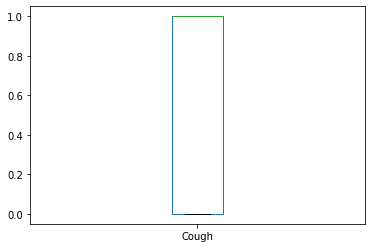

In [311]:
train_imputed.Cough.plot(kind='box')

<AxesSubplot:>

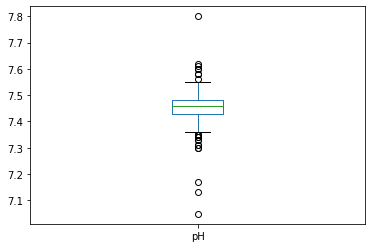

In [310]:
train.pH.plot(kind='box')

<AxesSubplot:>

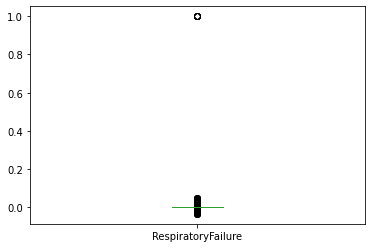

In [236]:
train_imputed.RespiratoryFailure.plot(kind='box')

<AxesSubplot:>

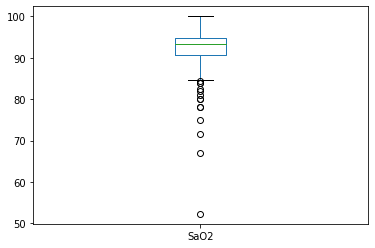

In [291]:
train_imputed.SaO2.plot(kind='box')

<AxesSubplot:>

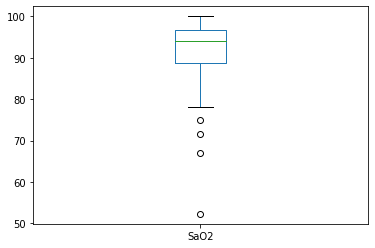

In [292]:
train.SaO2.plot(kind='box')

<AxesSubplot:>

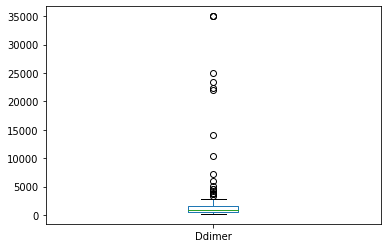

In [243]:
train.Ddimer.plot(kind='box')

<AxesSubplot:>

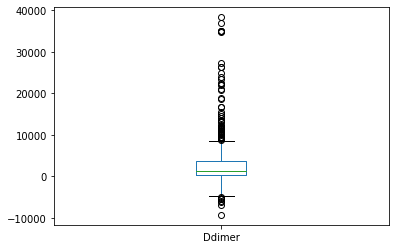

In [244]:
train_imputed.Ddimer.plot(kind='box')

In [5]:
# def make_train_test(df, col):
#     # only keep rows with no missing values in col
#     test = df.copy()
#     test.dropna(subset=[col], inplace=True)
    
#     # remove some values in col (same fraction as in complete dataset)
#     train_index = test.sample(frac=ratio_missing[col]).index
#     train = test.copy()
#     train.loc[train_index, col] = np.nan
    
#     return train, test

In [435]:
# # only keep rows with no missing values in col
# test = df.copy()
# test.dropna(subset=['Ox_percentage'], inplace=True)

# train = test.copy()

# # remove some values in col (same fraction as in complete dataset)
# test_index = test.sample(frac=ratio_missing['Ox_percentage']).index

# train.loc[test_index, 'Ox_percentage'] = np.nan

In [411]:
# test.Ox_percentage.isnull().mean()

0.0

In [412]:
# train.Ox_percentage.isnull().mean()

0.28225806451612906

In [37]:
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.pipeline import Pipeline

In [ ]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.means_ = None
        self.std_ = None

    def fit(self, X, y=None):
        X = X.to_numpy()
        self.means_ = X.mean(axis=0, keepdims=True)
        self.std_ = X.std(axis=0, keepdims=True)

        return self

    def transform(self, X, y=None):
        X[:] = (X.to_numpy() - self.means_) / self.std_

        return X